## Conditional DDPM/DDIM
### [CIFAR10 Code]

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from model.DiffusionModules import UNet_conditional, EMA
import torch.nn.functional as F
import cv2
from pytorch_model_summary import summary
import math
import os
from torchvision.datasets import ImageFolder
import random
import copy
from fastprogress import progress_bar
import wandb

/home/sha/anaconda3/envs/dvaa/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


make directories

In [2]:
if not os.path.exists(f"content"):
    os.makedirs(f"content")

if not os.path.exists(f"content/ddpm"):
    os.makedirs(f"content/ddpm")

if not os.path.exists(f"content/ddim"):
    os.makedirs(f"content/ddim")

if not os.path.exists(f"weight"):
    os.makedirs(f"weight")

Image Function (input: tensor)

In [3]:
def plot_images(images):
    plt.figure(figsize=(32, 32))
    long_image = torch.cat([(i+1.0)/2.0 for i in images.cpu()], dim=-1).permute(1, 2, 0).cpu() 
    plt.imshow(long_image)
    plt.axis('off')
    plt.show()

In [4]:
def save_images(images, path):
    long_image = torch.cat([((i+1.0)/2.0)*255.0 for i in images.cpu()], dim=-1).permute(1, 2, 0).cpu() 
    cv_image = cv2.cvtColor(long_image.numpy(), cv2.COLOR_BGR2RGB)
    cv_image = np.uint8(cv_image)
    cv2.imwrite(path, cv_image)

## Training Process

GPU check

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Dataset Loading

In [6]:
batch_size = 128
rsl = 32 

In [7]:
def make_loader(path, object='train', dir_size=1):
    transform = transforms.Compose([transforms.Resize((rsl, rsl)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    dataset = torchvision.datasets.ImageFolder(os.path.join(path, object), transform=transform)

    if dir_size > 1:
        dataset = torch.utils.data.Subset(dataset, indices=range(0, len(dataset), dir_size))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

In [8]:
path = '/home/sha/medical_system/cifar10_test/data/cifar-10-64'
train_loader = make_loader(path, object='train')
test_loader = make_loader(path, object='test')

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

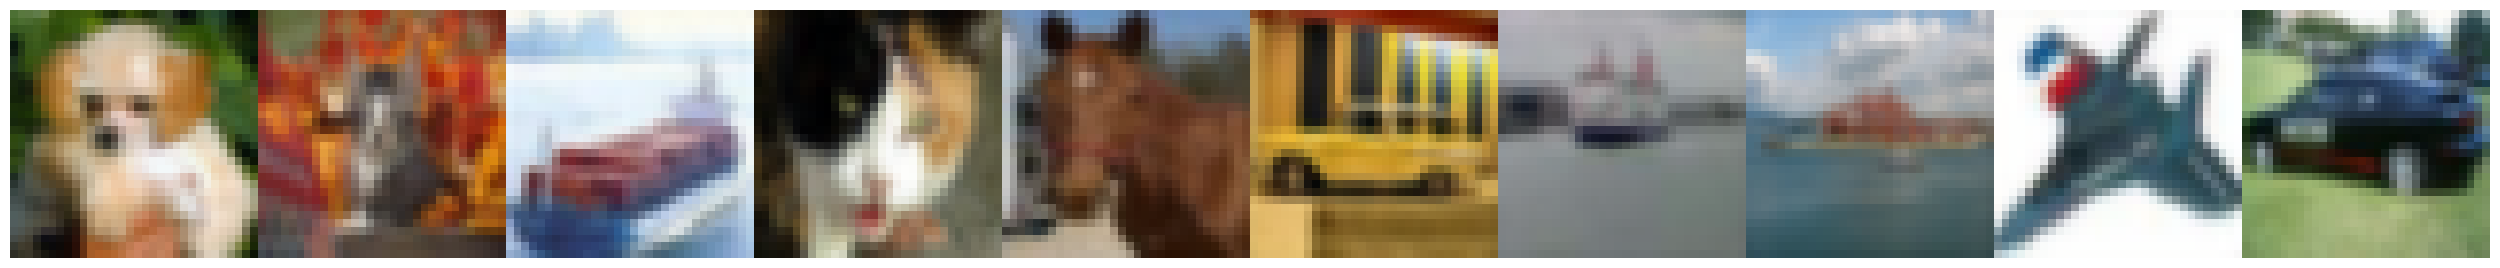

In [9]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

plot_images(images[:10])

Define Model

In [10]:
resolution=rsl
in_channels=3
num_classes = 10
other_dim=256

In [11]:
model = UNet_conditional(c_in=in_channels, c_out=in_channels, time_dim=other_dim, num_classes=num_classes).to(device)
model.train()

x = torch.ones([batch_size, in_channels, rsl, rsl]).cuda()
t = torch.ones([batch_size]).cuda()
c = torch.ones([batch_size], dtype=torch.long).cuda()

print(summary(model,x,t,c))
print('input:',x.shape,t.shape,c.shape)
print('output:',model(x,t,c).shape)
print('===================================')

---------------------------------------------------------------------------
       Layer (type)           Output Shape         Param #     Tr. Param #
        Embedding-1             [128, 256]           2,560           2,560
       DoubleConv-2      [128, 64, 32, 32]          38,848          38,848
             Down-3     [128, 128, 16, 16]         328,576         328,576
    SelfAttention-4     [128, 128, 16, 16]          99,584          99,584
             Down-5       [128, 256, 8, 8]       1,246,976       1,246,976
    SelfAttention-6       [128, 256, 8, 8]         395,776         395,776
             Down-7       [128, 256, 4, 4]       2,427,136       2,427,136
    SelfAttention-8       [128, 256, 4, 4]         395,776         395,776
       DoubleConv-9       [128, 512, 4, 4]       3,540,992       3,540,992
      DoubleConv-10       [128, 512, 4, 4]       4,720,640       4,720,640
      DoubleConv-11       [128, 256, 4, 4]       1,770,496       1,770,496
              Up-12     

Define EMA Model

In [12]:
ema = EMA(0.995)
ema_model = copy.deepcopy(model).eval().requires_grad_(False)

Diffusion Model Parameters

In [13]:
def beta_schedule(timesteps=1000, linear=True):
    scale = 1000 / timesteps
    if linear: 
        beta_start = scale * 0.0001
        beta_end = scale * 0.01
        return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float32)
    # quadratic 
    else:
        beta_start = (scale * 0.0001)**0.5
        beta_end = (scale * 0.01)**0.5
        return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float32)**2

In [14]:
beta_list = beta_schedule(timesteps=1000, linear=True)
alpha_list = 1.0 - beta_list
alpha_bar_list = torch.cumprod(alpha_list, dim=0)

sqrt_alpha_bar_list = torch.sqrt(alpha_bar_list)
sqrt_one_minus_alpha_bar_list = torch.sqrt(1.0 - alpha_bar_list)
one_div_sqrt_alpha_list = 1.0 / torch.sqrt(alpha_list)

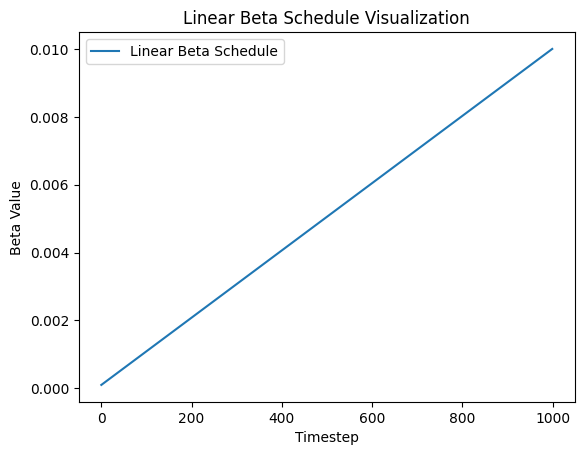

In [15]:
plt.plot(beta_list.numpy(), label='Linear Beta Schedule')
plt.xlabel('Timestep')
plt.ylabel('Beta Value')
plt.title('Linear Beta Schedule Visualization')
plt.legend()
plt.show()

Training Setting

In [16]:
learning_rate = 1e-4
epochs = 1000
timestep_num = 1000
save_epoch = 50

Set loss function and Optimizer

In [17]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-5)
sch = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(train_loader), epochs=epochs)
scaler = torch.cuda.amp.GradScaler()

DDIM Sampling

In [18]:
@torch.inference_mode()
def sampling(model, rsl=32, channels=3, num=10, total_timesteps=1000, sampling_timesteps=100, eta=0):
    print(f"\n Sampling {num} new images....")
    model.eval()

    c = [i for i in range(num)]
    c = np.array(c)

    # get time_pairs 
    times = torch.linspace(-1, total_timesteps - 1, steps = sampling_timesteps + 1)   # [-1, 0, 1, 2, ..., T-1] when sampling_timesteps == total_timesteps
    times = list(reversed(times.int().tolist()))
    time_pairs = list(zip(times[:-1], times[1:])) # [(T-1, T-2), (T-2, T-3), ..., (1, 0), (0, -1)]

    # get first image (noise)
    g_img = torch.randn((num, channels, rsl, rsl), dtype=torch.float32).to(device) 
    
    # Inference
    for time, time_next in progress_bar(time_pairs, total=len(time_pairs)):        
        in_t = torch.full((num,), time, dtype=torch.long).to(device)
        in_c = torch.tensor(c, dtype=torch.long).to(device)

        # model forward 
        pred_noise = model(g_img, in_t, in_c)

        # set alpha
        alpha = alpha_bar_list[time]
        alpha_next = alpha_bar_list[time_next]
        sqrt_alpha = torch.sqrt(alpha)
        sqrt_alpha_next = torch.sqrt(alpha_next)
    
        # predict x0
        numerator = g_img - (torch.sqrt(1-alpha) * pred_noise)
        pred_x0 = numerator / sqrt_alpha

        if time_next < 0:
            g_img = pred_x0
            
        else:        
            # predict direction_pointing 
            sigma = eta * torch.sqrt((1 - alpha_next) / (1 - alpha) * (1 - alpha / alpha_next))
            variance = sigma ** 2 
            direction_pointing = torch.sqrt(1-alpha_next-variance) * pred_noise

            # generate next image 
            g_img = (sqrt_alpha_next * pred_x0) + direction_pointing

    model.train()
    return g_img

Setting Path

In [19]:
SAVE_PATH = './weight/ddpm_cifar10'
BEST_SAVE_PATH = './weight/ddpm_cifar10_best.pth'
LAST_SAVE_PATH = './weight/ddpm_cifar10_last.pth'
CONTENT_PATH = './content/ddpm_cifar10'

losses = []
val_losses = [] 

Wandb

In [20]:
project_name = 'conditional_ddpm_cifar10'
wandb.init(project=project_name)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sunghyunahn (dvaa_sha). Use `wandb login --relogin` to force relogin


Training

In [ ]:
print('-------------------------------------------------------------------')
print("Training Start")
print('-------------------------------------------------------------------\n')
print("Training Status")

start_epoch = 0

for epoch in progress_bar(range(start_epoch, epochs), total=(epochs-start_epoch)):
    print('-------------------------------------------------------------------')
    print(f"[Training] {epoch+1}/{epochs}")
    running_loss = 0.0
    val_running_loss = 0.0

    pbar = progress_bar(train_loader, total=len(train_loader))
    for iter, data in enumerate(pbar):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        data_size = len(inputs)

        # get time, condition
        t = torch.randint(0, timestep_num, size=(data_size,), device=inputs.device).long()
        c = labels

        # Classifier Free Guidance (w=0.1)
        if np.random.random() < 0.1:
            c = None

        # forward process
        esp = torch.randn_like(inputs).to(device)
        noise_img = torch.zeros((data_size, in_channels, rsl, rsl), dtype=torch.float32).to(device)
        for i in range(data_size):
            alpha_bar = sqrt_alpha_bar_list[t[i]]
            one_minus_alpha_bar = sqrt_one_minus_alpha_bar_list[t[i]]
            noise_img[i] = alpha_bar * inputs[i] + one_minus_alpha_bar * esp[i]

        # reverse process [wandb]
        output = model(noise_img, t, c)
        loss = criterion(output, esp)
        pbar.comment = f"MSE={loss.item():2.3f}" 
        wandb.log({"train_mse_step": loss.item(),
                    "learning_rate": sch.get_last_lr()[0]})

        # optimization
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        ema.step_ema(ema_model, model) # EMA for stable training
        sch.step()
        running_loss += loss.item()
    
    # record training loss [wandb]
    losses.append(running_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")
    wandb.log({"train_mse_epoch": running_loss / len(train_loader)})

    # sampling [wandb]
    file_path = CONTENT_PATH + f"_epoch_{epoch+1}.png"
    g_img = sampling(model, rsl, channels=in_channels)
    g_img = torch.clip(g_img, -1.0, 1.0)
    plot_images(g_img)

    save_image = ((g_img + 1.0) / 2.0) * 255.
    wandb.log({"sampled_images":     [wandb.Image(img.permute(1,2,0).cpu().detach().numpy()) for img in save_image]})

    long_image = torch.cat([i for i in save_image.cpu().detach()], dim=-1).permute(1, 2, 0).cpu() 
    cv_image = cv2.cvtColor(long_image.numpy(), cv2.COLOR_BGR2RGB)
    cv_image = np.uint8(cv_image)
    cv2.imwrite(file_path, cv_image)

    # save model per [save_epoch] epoch
    if (epoch+1) % save_epoch == 0:
        torch.save(model.state_dict(), SAVE_PATH+f'_{epoch+1}epoch.pth')
        print('<< model save at [%d] epoch! >>' % (epoch+1))

    '''
    -------------------------
    validation per one epoch
    -------------------------
    '''
    print(f"[Validation] {epoch+1}/{epochs}")
    model.eval()
    for data in progress_bar(test_loader, total=len(test_loader)):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        data_size = len(inputs)

        # get time, condition
        t = torch.randint(0, timestep_num, size=(data_size,), device=inputs.device).long()
        c = labels

        # forward process
        esp = torch.randn_like(inputs).to(device)
        noise_img = torch.zeros((data_size, in_channels, rsl, rsl), dtype=torch.float32).to(device)
        for j in range(data_size):
            alpha_bar = sqrt_alpha_bar_list[t[j]]
            one_minus_alpha_bar = sqrt_one_minus_alpha_bar_list[t[j]]
            noise_img[j] = alpha_bar * inputs[j] + one_minus_alpha_bar * esp[j]

        # reverse process
        output = model(noise_img, t, c)
        loss = criterion(output, esp)
        val_running_loss += loss.item()

    # calculate avg val loss [wandb]
    val_loss = val_running_loss / len(test_loader)
    wandb.log({"val_mse_epoch": val_loss})

    # record validation loss
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs}, Valid Loss: {val_loss}")

    # early stopping
    if (epoch+1) > 1: 
        if val_loss < min(val_losses):
            best_epoch = epoch
            best_loss = np.round(val_loss,4)
            torch.save(model.state_dict(), BEST_SAVE_PATH)
            print('<<< Best model save at [%d] epoch! >>>' % (epoch+1))

    print('-------------------------------------------------------------------\n')
    model.train()

# last epoch -> save last model 
print("Training End")
torch.save(model.state_dict(), LAST_SAVE_PATH)
print("Last Model Saved")

NameError: name 'best_epoch' is not defined

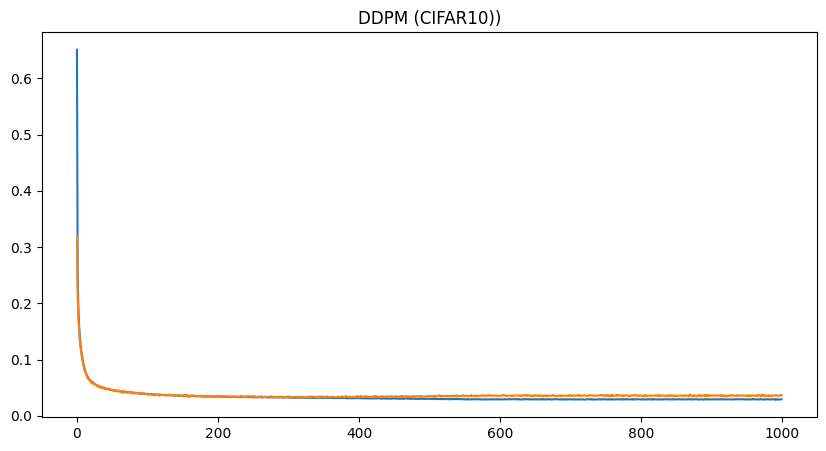

In [23]:
plt.figure(figsize=(10,5))
plt.title("DDPM (CIFAR10))")
plt.plot(losses,label="training loss")
plt.plot(val_losses,label="validation loss")
plt.axvline(best_epoch, color='green', linestyle='--', linewidth=2, label=f"early stopping ({best_epoch}, loss:{best_loss})")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Generating Process

model

In [24]:
in_channels = 3
other_dim = 256
num_classes = 10

In [25]:
model = UNet_conditional(c_in=in_channels, c_out=in_channels, time_dim=other_dim, num_classes=num_classes).to(device)
SAVED_PATH = '/home/sha/medical_system/cifar10_test/weight/ddpm_cifar10_1000epoch.pth'

try:
    model.load_state_dict(torch.load(SAVED_PATH))
    model.eval()
    print('load model ok!')
except:
    print('error')

load model ok!


image setting

In [26]:
c_size = 10 
batch_size = c_size ** 2 
rsl = 32
width = rsl * c_size
height = rsl * c_size
channels = 3
timestep_num = 1000

condition

In [27]:
c = [(i%c_size) for i in range(c_size*c_size)]
c = np.array(c)

make video (ddpm inversion)

In [28]:
with torch.no_grad():
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    out = cv2.VideoWriter('./content/ddpm/ddpm_cifar10.avi', fourcc, 20, (height, width))
    out_img = np.zeros((height,width,channels)) # [320, 320, 3]

    # get first image (noise)
    g_img = torch.randn((batch_size, channels, rsl, rsl), dtype=torch.float32).to(device) # [100, 3, 32, 32]
    
    # Inference 
    for t in range(timestep_num - 1, -1, -1): # 999 ~ 0 => 1000 step to 1 step 
        in_t = torch.full((batch_size,), t, dtype=torch.long).to(device)
        in_c = torch.tensor(c, dtype=torch.long).to(device)

        # forward 
        pred_noise = model(g_img, in_t, in_c)

        # get t-th images 
        if t > 0:
            z = torch.randn((batch_size, channels, rsl, rsl), dtype=torch.float32).to(device) # [100, 3, 32, 32]
        else:
            z = torch.zeros_like(g_img)
        mu = one_div_sqrt_alpha_list[t] * (g_img - (beta_list[t] / sqrt_one_minus_alpha_bar_list[t]) * pred_noise)
        g_img = mu + (torch.sqrt(beta_list[t])*z)

        # make numpy images
        g_np = ((torch.clip(g_img, -1.0, 1.0) + 1.0) / 2.0) * 255. # [100, 3, 32, 32]
        g_np = g_np.permute(0,2,3,1).cpu().detach().numpy() # [100, 32, 32, 3]
        
        # reshape numpy images
        rs_img = np.resize(g_np, (c_size, c_size, rsl, rsl, channels)) # [10, 10, 32, 32, 3]

        # make numpy images to grid image
        for i in range(c_size):
            for j in range(c_size):
                for cnl in range(channels):
                    out_img[i * rsl:i * rsl +rsl, j * rsl:j * rsl +rsl, cnl] = rs_img[i, j, :, :, cnl]

        # make video 
        out_img = np.uint8(out_img)
        out_img = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
        out.write(out_img)

        # save grid image per 100 time step 
        if ((t+1) < 1000) and ((t+1) % 100 == 0):
            print(f'{t+1} step')
            file_path = f"./content/ddpm/{t+1}_step_img.png"
            cv2.imwrite(file_path, out_img)

    # finish
    file_path = f"./content/ddpm/last_img.png"
    cv2.imwrite(file_path, out_img)
    out.release()
    print('save video_ddpm ok!')

900 step
800 step
700 step
600 step
500 step
400 step
300 step
200 step
100 step
save video_ddpm ok!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


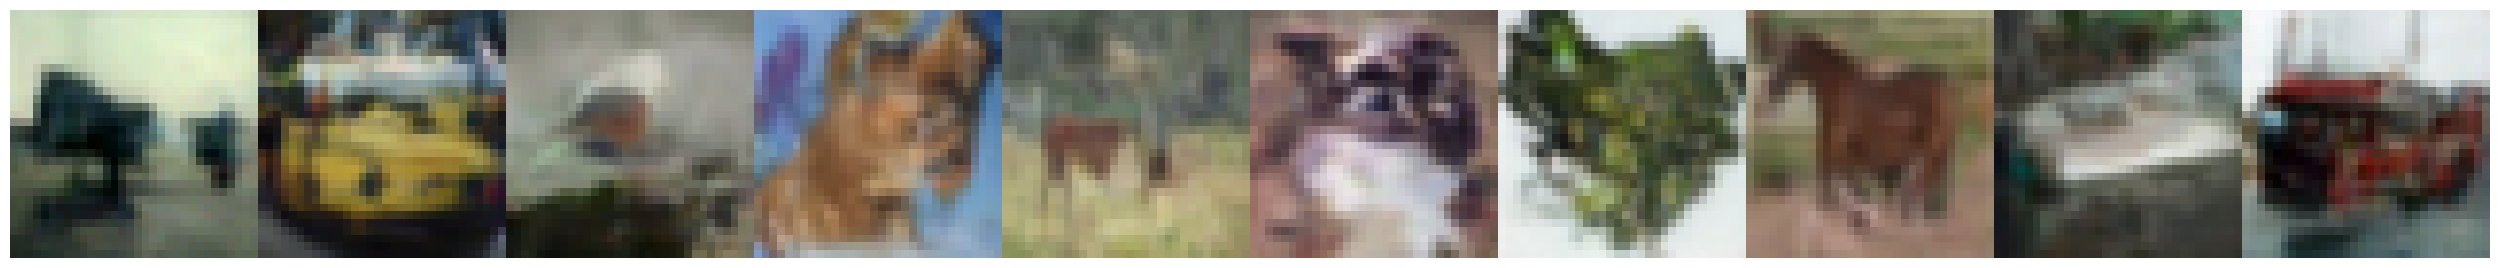

In [30]:
plot_images(g_img[:10].cpu())

make video (ddim inversion)

- eta = 0 -> ddim mode (low FID = high fidelity, diversity)
- eta = 1 -> ddpm mode (high FID = low fidelity, diversity)

In [31]:
total_timesteps  = 1000
sampling_timesteps = 100 # 10 times faster

In [32]:
def objective(ddim=True):
    if ddim:
        return 0
    else:
        return 1
    
eta = objective(True)
print('eta:',eta)

eta: 0


In [33]:
with torch.no_grad():
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    out = cv2.VideoWriter('./content/ddim/ddim_cifar10.avi', fourcc, 20, (width, height))
    out_img = np.zeros((height,width,3)) # [320, 320, 3]

    # get first image (noise)
    g_img = torch.randn((batch_size, 3, rsl, rsl), dtype=torch.float32).to(device) # [100, 3, 32, 32]

    # get time_pairs 
    times = torch.linspace(-1, total_timesteps - 1, steps = sampling_timesteps + 1)   # [-1, 0, 1, 2, ..., T-1] when sampling_timesteps == total_timesteps
    times = list(reversed(times.int().tolist()))
    time_pairs = list(zip(times[:-1], times[1:])) # [(T-1, T-2), (T-2, T-3), ..., (1, 0), (0, -1)]
    
    # Inference
    for time, time_next in time_pairs:        
        in_t = torch.full((batch_size,), time, dtype=torch.long).to(device)
        in_c = torch.tensor(c, dtype=torch.long).to(device)

        # model forward 
        pred_noise = model(g_img, in_t, in_c)

        # set alpha
        alpha = alpha_bar_list[time]
        alpha_next = alpha_bar_list[time_next]
        sqrt_alpha = torch.sqrt(alpha)
        sqrt_alpha_next = torch.sqrt(alpha_next)
    
        # predict x0
        numerator = g_img - (torch.sqrt(1-alpha) * pred_noise)
        pred_x0 = numerator / sqrt_alpha

        if time_next < 0:
            g_img = pred_x0
            
        else:        
            # predict direction_pointing 
            sigma = eta * torch.sqrt((1 - alpha_next) / (1 - alpha) * (1 - alpha / alpha_next))
            variance = sigma ** 2 
            direction_pointing = torch.sqrt(1-alpha_next-variance) * pred_noise

            # generate next image 
            g_img = (sqrt_alpha_next * pred_x0) + direction_pointing

        # make numpy images
        g_np = ((torch.clip(g_img, -1.0, 1.0) + 1.0) / 2.0) * 255. # [100, 3, 32, 32]
        g_np = g_np.permute(0,2,3,1).cpu().detach().numpy() # [100, 32, 32, 3]
    
        # reshape numpy images
        rs_img = np.resize(g_np, (c_size, c_size, rsl, rsl, 3)) # [10, 10, 32, 32, 3]

        # make numpy images to grid image
        for i in range(c_size):
            for j in range(c_size):
                out_img[i * rsl:i * rsl +rsl, j * rsl:j * rsl +rsl, 0] = rs_img[i, j, :, :, 0]
                out_img[i * rsl:i * rsl +rsl, j * rsl:j * rsl +rsl, 1] = rs_img[i, j, :, :, 1]
                out_img[i * rsl:i * rsl +rsl, j * rsl:j * rsl +rsl, 2] = rs_img[i, j, :, :, 2]

        # make video 
        out_img = np.uint8(out_img)
        out_img = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
        out.write(out_img)

        # save grid image per sampling time step 
        print(f'{time+1} step')
        file_path = f"./content/ddim/{time+1}_step_img.png"
        cv2.imwrite(file_path, out_img)

    # finish
    file_path = f"./content/ddim/last_img.png"
    cv2.imwrite(file_path, out_img)
    out.release()
    print('save video_ddim ok!')

1000 step
990 step
980 step
970 step
960 step
950 step
940 step
930 step
920 step
910 step
900 step
890 step
880 step
870 step
860 step
850 step
840 step
830 step
820 step
810 step
800 step
790 step
780 step
770 step
760 step
750 step
740 step
730 step
720 step
710 step
700 step
690 step
680 step
670 step
660 step
650 step
640 step
630 step
620 step
610 step
600 step
590 step
580 step
570 step
560 step
550 step
540 step
530 step
520 step
510 step
500 step
490 step
480 step
470 step
460 step
450 step
440 step
430 step
420 step
410 step
400 step
390 step
380 step
370 step
360 step
350 step
340 step
330 step
320 step
310 step
300 step
290 step
280 step
270 step
260 step
250 step
240 step
230 step
220 step
210 step
200 step
190 step
180 step
170 step
160 step
150 step
140 step
130 step
120 step
110 step
100 step
90 step
80 step
70 step
60 step
50 step
40 step
30 step
20 step
10 step
save video_ddim ok!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


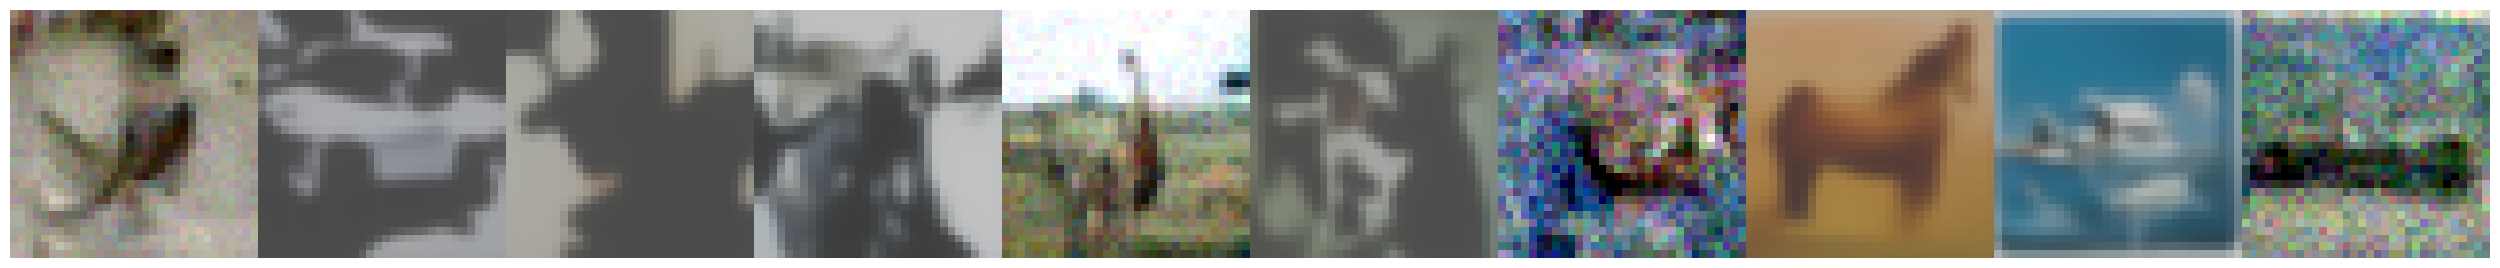

In [34]:
plot_images(g_img[:10].cpu())